In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings('ignore')


In [2]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Concatenate, Activation, Add, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model, Sequential, load_model

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)


In [3]:
class BiGAN(keras.Model):
    def __init__(self, d_shape, z_dim):
        super(BiGAN, self).__init__()
        self.d_shape = d_shape
        self.z_dim = z_dim
        
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.encoder = self.build_encoder()
    
    def compile(self, g_optim, d_optim, e_optim, loss_fn):
        super(BiGAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.e_optim = e_optim
        self.loss_fn = loss_fn
        
    def build_encoder(self):
        activation = 'relu'
        inputs = Input(shape = (self.d_shape[1], ))
        
        h = Dense(512, kernel_initializer='he_normal')(inputs)
        h = Activation(activation)(h)
        
        h = Dense(256, kernel_initializer='he_normal')(h)
        h = Activation(activation)(h)

        outputs = Dense(self.z_dim)(h)
        
        return Model(inputs, outputs, name='encoder')
        
    def build_generator(self):
        activation = 'relu'
        inputs = Input(shape=(self.z_dim, ))
        
        h = Dense(128, kernel_initializer='he_normal')(inputs)
        h = Activation(activation)(h)
        
        h = Dense(256, kernel_initializer='he_normal')(h)
        h = Activation(activation)(h)
        
        h = Dense(512, kernel_initializer='he_normal')(h)
        h = Activation(activation)(h)
        
        outputs = Dense(self.d_shape[1], kernel_initializer='he_normal', activation='tanh')(h)
        return Model(inputs, outputs, name='generator')
    
    def build_discriminator(self):
        activation = 'relu'
        
        r = Input(shape = (self.d_shape[1], )) # target
        z = Input(shape = (self.z_dim, )) # latent space
        inputs = Concatenate()([r, z])
        
        h = Dense(512, kernel_initializer='he_normal')(inputs)
        h = Activation(activation)(h)
        
        h = Dense(256, kernel_initializer='he_normal')(h)
        h = Activation(activation)(h)
        
        outputs = Dense(1)(h)
        
        return Model([r, z], outputs, name='dicriminator')
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]
        
        noise = tf.random.normal((batch_size, self.z_dim))

        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([fake_labels, real_labels], 0)

        # disc
        with tf.GradientTape() as tape:
            # real 
            enc = self.encoder(x)
            preds_real = self.discriminator([x, enc])
            # fake
            preds_gen = self.generator(noise)
            preds_fake = self.discriminator([preds_gen, noise])
            # concat
            preds = tf.concat([preds_fake, preds_real], 0)
            
            d_loss = self.loss_fn(labels, preds)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # gen
        with tf.GradientTape() as tape:
            preds_gen = self.generator(noise)
            preds = self.discriminator([preds_gen, noise])
            g_loss = self.loss_fn(real_labels, preds)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))
            
        # enc
        with tf.GradientTape() as tape:
            enc = self.encoder(x)
            preds = self.discriminator([x, enc])
            e_loss = self.loss_fn(fake_labels, preds)
            
        grads = tape.gradient(e_loss, self.encoder.trainable_weights)
        self.e_optim.apply_gradients(zip(grads, self.encoder.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss, 'e_loss': e_loss}

In [4]:
import matplotlib.pyplot as plt

def sample_images(fname=None):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r*c, 100))
    imgs = gan.generator.predict(noise)*0.5 +0.5
    imgs = imgs.reshape(r*c, 28, 28)
    fig, axs = plt.subplots(r, c)
    n = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(imgs[n], cmap='gray')
            axs[i,j].axis('off')
            n += 1

    if fname is not None:
        plt.savefig(f'{fname}.png')

    plt.show()
    plt.close()
    
class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epochs, logs=None):
        if epochs % 10 == 0:
            sample_images()

In [5]:
# prepare data
from tensorflow.keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
X = train_X.reshape(-1, 28*28)

In [6]:
gan = BiGAN(X.shape, 100)
gan.discriminator.summary()
gan.generator.summary()
gan.encoder.summary()

Model: "dicriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 884)          0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          453120      concatenate[0][0]     

In [7]:
gan.compile(optimizers.Adam(2e-4, 0.5), # g
           optimizers.Adam(2e-4, 0.5), # d
           optimizers.Adam(2e-4, 0.5), # e
           losses.BinaryCrossentropy(from_logits=True))

Epoch 1/101


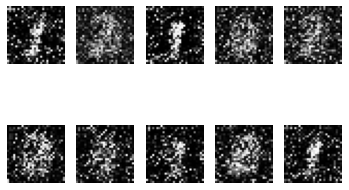

1875/1875 - 12s - d_loss: 0.5830 - g_loss: 1.3612 - e_loss: 2.7382
Epoch 2/101
1875/1875 - 11s - d_loss: 0.3965 - g_loss: 1.7629 - e_loss: 1.9757
Epoch 3/101
1875/1875 - 11s - d_loss: 0.4503 - g_loss: 1.2715 - e_loss: 2.5451
Epoch 4/101
1875/1875 - 12s - d_loss: 0.4959 - g_loss: 1.4492 - e_loss: 1.4295
Epoch 5/101
1875/1875 - 11s - d_loss: 0.4455 - g_loss: 1.5345 - e_loss: 1.8842
Epoch 6/101
1875/1875 - 12s - d_loss: 0.4646 - g_loss: 1.3268 - e_loss: 2.6664
Epoch 7/101
1875/1875 - 12s - d_loss: 0.4271 - g_loss: 1.5118 - e_loss: 2.0369
Epoch 8/101
1875/1875 - 12s - d_loss: 0.4711 - g_loss: 1.9764 - e_loss: 1.3573
Epoch 9/101
1875/1875 - 12s - d_loss: 0.5290 - g_loss: 1.1886 - e_loss: 1.5163
Epoch 10/101
1875/1875 - 12s - d_loss: 0.7079 - g_loss: 1.1080 - e_loss: 1.7375
Epoch 11/101


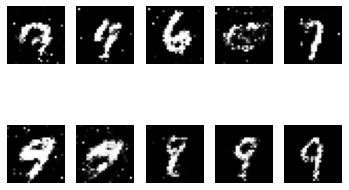

1875/1875 - 12s - d_loss: 0.7098 - g_loss: 1.2396 - e_loss: 1.5780
Epoch 12/101
1875/1875 - 11s - d_loss: 0.6047 - g_loss: 1.3125 - e_loss: 1.6791
Epoch 13/101
1875/1875 - 12s - d_loss: 0.5209 - g_loss: 1.3429 - e_loss: 1.5910
Epoch 14/101
1875/1875 - 11s - d_loss: 0.5736 - g_loss: 1.2543 - e_loss: 1.3425
Epoch 15/101
1875/1875 - 11s - d_loss: 0.6489 - g_loss: 1.1011 - e_loss: 1.3686
Epoch 16/101
1875/1875 - 12s - d_loss: 0.5025 - g_loss: 1.2879 - e_loss: 1.3916
Epoch 17/101
1875/1875 - 11s - d_loss: 0.4994 - g_loss: 1.3232 - e_loss: 1.4723
Epoch 18/101
1875/1875 - 11s - d_loss: 0.5234 - g_loss: 1.3610 - e_loss: 1.3331
Epoch 19/101
1875/1875 - 12s - d_loss: 0.5725 - g_loss: 1.2533 - e_loss: 1.3625
Epoch 20/101
1875/1875 - 11s - d_loss: 0.6365 - g_loss: 1.3629 - e_loss: 1.1656
Epoch 21/101


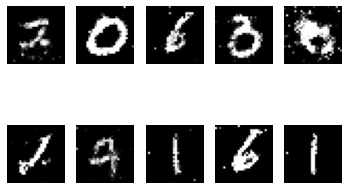

1875/1875 - 12s - d_loss: 0.5562 - g_loss: 1.5027 - e_loss: 1.6011
Epoch 22/101
1875/1875 - 12s - d_loss: 0.5782 - g_loss: 1.3428 - e_loss: 1.3876
Epoch 23/101
1875/1875 - 11s - d_loss: 0.5984 - g_loss: 1.1729 - e_loss: 1.5498
Epoch 24/101
1875/1875 - 12s - d_loss: 0.4977 - g_loss: 1.3510 - e_loss: 1.5154
Epoch 25/101
1875/1875 - 12s - d_loss: 0.5507 - g_loss: 1.6120 - e_loss: 1.5408
Epoch 26/101
1875/1875 - 11s - d_loss: 0.5290 - g_loss: 1.3544 - e_loss: 1.7250
Epoch 27/101
1875/1875 - 12s - d_loss: 0.5615 - g_loss: 1.1932 - e_loss: 1.4674
Epoch 28/101
1875/1875 - 12s - d_loss: 0.5565 - g_loss: 1.3692 - e_loss: 1.6594
Epoch 29/101
1875/1875 - 11s - d_loss: 0.6856 - g_loss: 1.0242 - e_loss: 1.4767
Epoch 30/101
1875/1875 - 11s - d_loss: 0.4482 - g_loss: 1.4146 - e_loss: 1.5284
Epoch 31/101


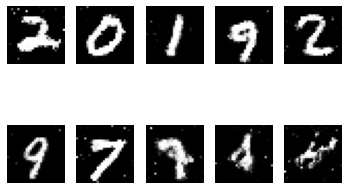

1875/1875 - 12s - d_loss: 0.5445 - g_loss: 1.3848 - e_loss: 1.2749
Epoch 32/101
1875/1875 - 11s - d_loss: 0.6271 - g_loss: 1.1235 - e_loss: 1.3302
Epoch 33/101
1875/1875 - 12s - d_loss: 0.6101 - g_loss: 1.1754 - e_loss: 1.2961
Epoch 34/101
1875/1875 - 12s - d_loss: 0.5550 - g_loss: 1.4197 - e_loss: 1.3215
Epoch 35/101
1875/1875 - 11s - d_loss: 0.5742 - g_loss: 1.3524 - e_loss: 1.5284
Epoch 36/101
1875/1875 - 12s - d_loss: 0.4782 - g_loss: 1.5808 - e_loss: 1.2988
Epoch 37/101
1875/1875 - 12s - d_loss: 0.5309 - g_loss: 1.2309 - e_loss: 1.4848
Epoch 38/101
1875/1875 - 11s - d_loss: 0.5526 - g_loss: 1.5035 - e_loss: 1.1881
Epoch 39/101
1875/1875 - 12s - d_loss: 0.4944 - g_loss: 1.3225 - e_loss: 1.4100
Epoch 40/101
1875/1875 - 12s - d_loss: 0.6482 - g_loss: 1.2553 - e_loss: 1.2420
Epoch 41/101


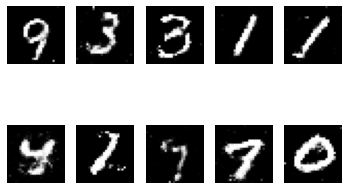

1875/1875 - 12s - d_loss: 0.6142 - g_loss: 1.4298 - e_loss: 1.2697
Epoch 42/101
1875/1875 - 12s - d_loss: 0.5810 - g_loss: 1.2141 - e_loss: 1.3267
Epoch 43/101
1875/1875 - 11s - d_loss: 0.5478 - g_loss: 1.3752 - e_loss: 1.3927
Epoch 44/101
1875/1875 - 11s - d_loss: 0.5474 - g_loss: 1.3964 - e_loss: 1.3011
Epoch 45/101
1875/1875 - 12s - d_loss: 0.4972 - g_loss: 1.4123 - e_loss: 1.4236
Epoch 46/101
1875/1875 - 12s - d_loss: 0.5410 - g_loss: 1.2872 - e_loss: 1.3905
Epoch 47/101
1875/1875 - 11s - d_loss: 0.6602 - g_loss: 1.1222 - e_loss: 1.1055
Epoch 48/101
1875/1875 - 12s - d_loss: 0.5761 - g_loss: 1.4604 - e_loss: 1.3018
Epoch 49/101
1875/1875 - 11s - d_loss: 0.5454 - g_loss: 1.3000 - e_loss: 1.4722
Epoch 50/101
1875/1875 - 12s - d_loss: 0.5043 - g_loss: 1.2569 - e_loss: 1.4773
Epoch 51/101


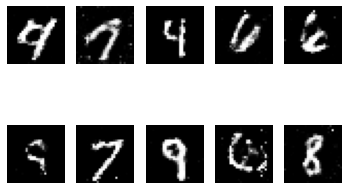

1875/1875 - 12s - d_loss: 0.6189 - g_loss: 1.3113 - e_loss: 1.2290
Epoch 52/101
1875/1875 - 12s - d_loss: 0.6612 - g_loss: 1.3356 - e_loss: 1.0132
Epoch 53/101
1875/1875 - 12s - d_loss: 0.6170 - g_loss: 1.1389 - e_loss: 1.1882
Epoch 54/101
1875/1875 - 12s - d_loss: 0.5589 - g_loss: 1.5915 - e_loss: 1.1776
Epoch 55/101
1875/1875 - 11s - d_loss: 0.6610 - g_loss: 1.2821 - e_loss: 1.0594
Epoch 56/101
1875/1875 - 12s - d_loss: 0.4602 - g_loss: 1.4539 - e_loss: 1.6182
Epoch 57/101
1875/1875 - 12s - d_loss: 0.5754 - g_loss: 1.1808 - e_loss: 1.5038
Epoch 58/101
1875/1875 - 8s - d_loss: 0.5889 - g_loss: 1.2298 - e_loss: 1.4806
Epoch 59/101
1875/1875 - 5s - d_loss: 0.5363 - g_loss: 1.4676 - e_loss: 1.3622
Epoch 60/101
1875/1875 - 5s - d_loss: 0.5535 - g_loss: 1.2108 - e_loss: 1.4491
Epoch 61/101


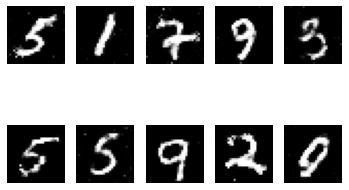

1875/1875 - 5s - d_loss: 0.6492 - g_loss: 1.2750 - e_loss: 1.2306
Epoch 62/101
1875/1875 - 5s - d_loss: 0.5399 - g_loss: 1.5113 - e_loss: 1.3968
Epoch 63/101
1875/1875 - 5s - d_loss: 0.5391 - g_loss: 1.4467 - e_loss: 1.4309
Epoch 64/101
1875/1875 - 5s - d_loss: 0.4856 - g_loss: 1.4427 - e_loss: 1.4161
Epoch 65/101
1875/1875 - 5s - d_loss: 0.5696 - g_loss: 1.4629 - e_loss: 1.3131
Epoch 66/101
1875/1875 - 5s - d_loss: 0.4921 - g_loss: 1.4643 - e_loss: 1.4977
Epoch 67/101
1875/1875 - 5s - d_loss: 0.5519 - g_loss: 1.3953 - e_loss: 1.3480
Epoch 68/101
1875/1875 - 5s - d_loss: 0.5779 - g_loss: 1.4461 - e_loss: 1.3878
Epoch 69/101
1875/1875 - 5s - d_loss: 0.6587 - g_loss: 1.1593 - e_loss: 1.2815
Epoch 70/101
1875/1875 - 5s - d_loss: 0.4737 - g_loss: 1.4642 - e_loss: 1.4730
Epoch 71/101


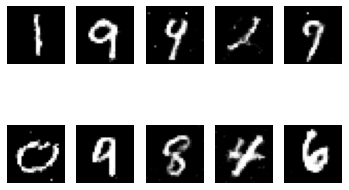

1875/1875 - 5s - d_loss: 0.5364 - g_loss: 1.2613 - e_loss: 1.6183
Epoch 72/101
1875/1875 - 5s - d_loss: 0.6429 - g_loss: 1.1078 - e_loss: 1.2998
Epoch 73/101
1875/1875 - 5s - d_loss: 0.5749 - g_loss: 1.4276 - e_loss: 1.3403
Epoch 74/101
1875/1875 - 5s - d_loss: 0.6106 - g_loss: 1.3916 - e_loss: 1.1794
Epoch 75/101
1875/1875 - 5s - d_loss: 0.5786 - g_loss: 1.2192 - e_loss: 1.3741
Epoch 76/101
1875/1875 - 5s - d_loss: 0.6576 - g_loss: 1.3016 - e_loss: 1.0608
Epoch 77/101
1875/1875 - 5s - d_loss: 0.4404 - g_loss: 1.4557 - e_loss: 1.5931
Epoch 78/101
1875/1875 - 5s - d_loss: 0.5460 - g_loss: 1.1941 - e_loss: 1.6989
Epoch 79/101
1875/1875 - 5s - d_loss: 0.5505 - g_loss: 1.4360 - e_loss: 1.3305
Epoch 80/101
1875/1875 - 5s - d_loss: 0.5983 - g_loss: 1.2183 - e_loss: 1.2540
Epoch 81/101


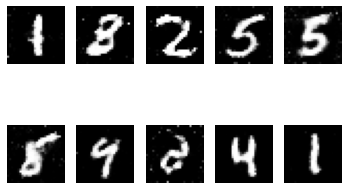

1875/1875 - 6s - d_loss: 0.5962 - g_loss: 1.3135 - e_loss: 1.2824
Epoch 82/101
1875/1875 - 5s - d_loss: 0.6600 - g_loss: 1.0223 - e_loss: 1.3806
Epoch 83/101
1875/1875 - 5s - d_loss: 0.5262 - g_loss: 1.2625 - e_loss: 1.6812
Epoch 84/101
1875/1875 - 5s - d_loss: 0.6114 - g_loss: 1.2259 - e_loss: 1.3496
Epoch 85/101
1875/1875 - 5s - d_loss: 0.5990 - g_loss: 1.2322 - e_loss: 1.4159
Epoch 86/101
1875/1875 - 5s - d_loss: 0.5048 - g_loss: 1.4230 - e_loss: 1.3312
Epoch 87/101
1875/1875 - 5s - d_loss: 0.6087 - g_loss: 1.3064 - e_loss: 1.1928
Epoch 88/101
1875/1875 - 5s - d_loss: 0.5735 - g_loss: 1.4161 - e_loss: 1.4280
Epoch 89/101
1875/1875 - 5s - d_loss: 0.6042 - g_loss: 1.0795 - e_loss: 1.3927
Epoch 90/101
1875/1875 - 5s - d_loss: 0.4591 - g_loss: 1.4555 - e_loss: 1.4207
Epoch 91/101


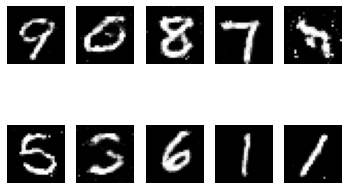

1875/1875 - 6s - d_loss: 0.5339 - g_loss: 1.3212 - e_loss: 1.7637
Epoch 92/101
1875/1875 - 6s - d_loss: 0.5440 - g_loss: 1.2886 - e_loss: 1.5865
Epoch 93/101
1875/1875 - 5s - d_loss: 0.6377 - g_loss: 1.3286 - e_loss: 1.2811
Epoch 94/101
1875/1875 - 5s - d_loss: 0.5628 - g_loss: 1.2652 - e_loss: 1.3418
Epoch 95/101
1875/1875 - 6s - d_loss: 0.6374 - g_loss: 1.2580 - e_loss: 1.4143
Epoch 96/101
1875/1875 - 6s - d_loss: 0.5375 - g_loss: 1.3395 - e_loss: 1.3835
Epoch 97/101
1875/1875 - 6s - d_loss: 0.5860 - g_loss: 1.3050 - e_loss: 1.1951
Epoch 98/101
1875/1875 - 6s - d_loss: 0.5947 - g_loss: 1.2425 - e_loss: 1.3721
Epoch 99/101
1875/1875 - 6s - d_loss: 0.4978 - g_loss: 1.3019 - e_loss: 1.5612
Epoch 100/101
1875/1875 - 6s - d_loss: 0.5133 - g_loss: 1.3918 - e_loss: 1.4428
Epoch 101/101


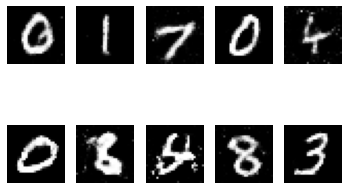

1875/1875 - 6s - d_loss: 0.5891 - g_loss: 1.2237 - e_loss: 1.3477


In [8]:
gan.fit(X,
       epochs=101,
       shuffle=True,
       verbose=2,
       callbacks=[PlotCallback()],
       batch_size=32)

origin


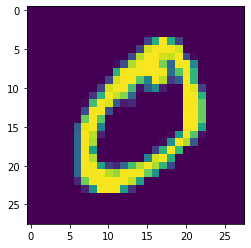

re-con


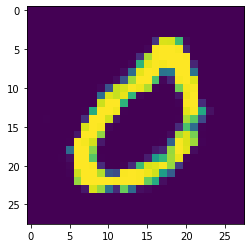

##################################################
origin


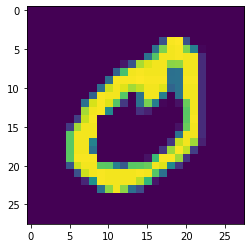

re-con


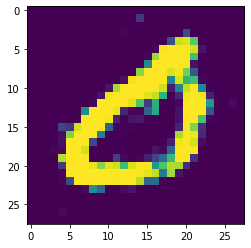

##################################################
origin


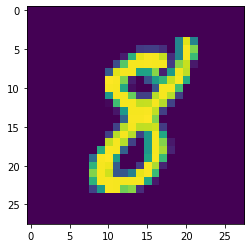

re-con


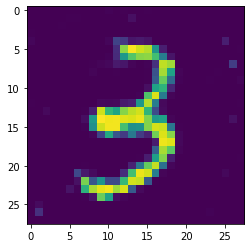

##################################################
origin


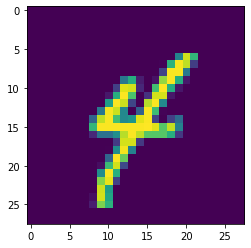

re-con


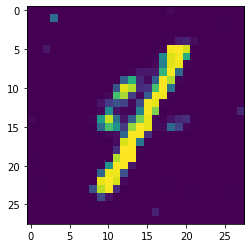

##################################################
origin


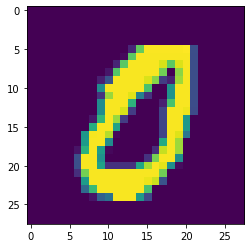

re-con


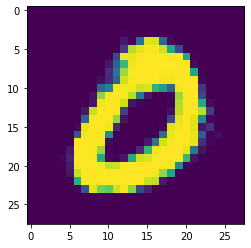

##################################################
origin


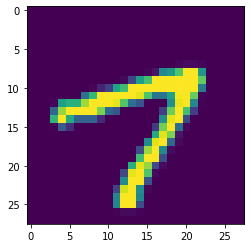

re-con


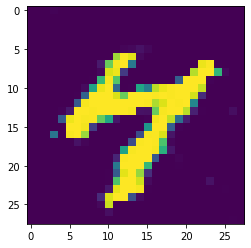

##################################################
origin


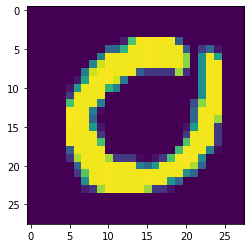

re-con


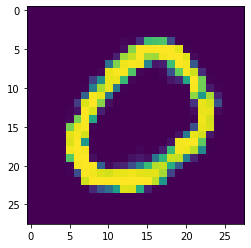

##################################################
origin


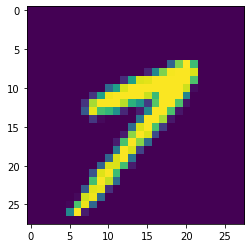

re-con


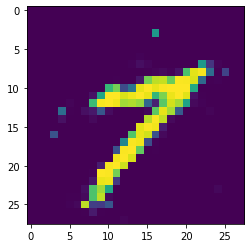

##################################################
origin


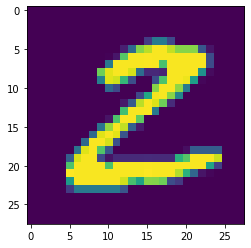

re-con


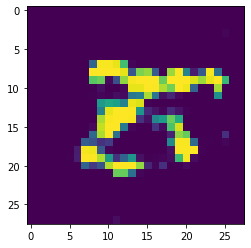

##################################################
origin


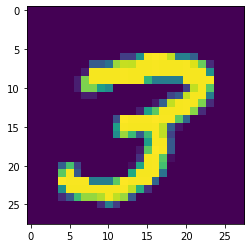

re-con


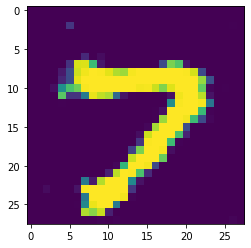

##################################################


In [9]:
for i in range(1, 201, 20):
    print('origin')
    img = X[i]
    img = img.reshape(28, 28)
    plt.imshow(img)
    plt.show()
    
    print('re-con')
    z = gan.encoder.predict(X[i].reshape(1, -1))
    fake = gan.generator.predict(z)
    fake = fake.reshape(28, 28)
    plt.imshow(fake)
    plt.show()
    print('#'*50)